# Inerpretation-Net Training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes

config = {
    'data': {
        'd': 3, #degree
        'n': 5, #number of variables
        'monomial_vars': None, #int or None
        'laurent': False, #use Laurent polynomials (negative degree with up to -d)  
        'neg_d': 0,#int or None
        'neg_d_prob': 0,
        'sparsity': None,
        'sample_sparsity': 5,
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'lambda_nets_total': 50000,
        'noise': 0,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'border_min': 0.2, #needs to be between 0 and (x_max-x_min)/2
        'border_max': 0.4,
        'lower_degree_prob': 0.5,
        'a_zero_prob': 0.25,
        'a_random_prob': 0.1,      
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
    },
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True,  #if early stopping is used, multi_epoch_analysis is deactivated
        'early_stopping_min_delta_lambda': 1e-4,
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sample_sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'mae',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 5000,
    },
    'i_net': {
        'optimizer': 'custom',#adam
        'inet_loss': 'mae',
        'inet_metrics': ['r2'],
        'dropout': 0.25,
        'dropout_output': 0,
        'epochs': 500, 
        'early_stopping': True,
        'batch_size': 256,
        'dense_layers': [512, 1024],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 50000,
                
        'interpretation_net_output_monomials': 5, #(None, int) #CONSTANT IS NOT INCLUDED
        'interpretation_net_output_shape': None, #calculated automatically later
        'test_size': 100, #Float for fraction, Int for number 0
        
        'normalize_inet_data': False,
        'inet_training_without_noise': False, #dataset size without noise hardcoded to 50k in generate_paths
        'sparse_poly_representation_version': 2, #(1, 2); 1=old, 2=new

        'evaluate_with_real_function': True, #False
        'consider_labels_training': True, #False
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': False,
        'nas_type': 'SEQUENTIAL', #options:(None, 'SEQUENTIAL', 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 100,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 100,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
        
        'symbolic_metamodeling_evaluation': False,
        'symbolic_metamodeling_poly_evaluation': False,
        'symbolic_metamodeling_function_evaluation': False,
        'symbolic_metamodeling_poly_function_evaluation': False,
        
        'symbolic_regression_evaluation': False,
        'per_network_evaluation': False,
    },
    'computation':{
        'n_jobs': 10,
        'use_gpu': True,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import os
import shutil

import logging

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score

from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.utils import plot_model
from IPython.display import Image

import keras.backend as K
from livelossplot import PlotLossesKerasTF
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib import pyplot as plt
import seaborn as sns


import tensorflow as tf
import random 


import warnings


from IPython.display import display, Math, Latex, clear_output



In [4]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

multi_epoch_analysis = False if early_stopping_lambda else multi_epoch_analysis #deactivate multi_epoch_analysis if early stopping is used

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

data_reshape_version = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

logging.getLogger('tensorflow').disabled = True

sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

sys.path.append('..')

In [5]:
from utilities.utility_functions import flatten, rec_gen, gen_monomial_identifier_list

list_of_monomial_identifiers_extended = []

if laurent:
    variable_sets = [list(flatten([[_d for _d in range(d+1)], [-_d for _d in range(1, neg_d+1)]])) for _ in range(n)]
    list_of_monomial_identifiers_extended = rec_gen(variable_sets)    
        
    print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
    #print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
    #print('Sparsity:' + str(sparsity))
    if len(list_of_monomial_identifiers_extended) < 500:
        print(list_of_monomial_identifiers_extended)     
        
    list_of_monomial_identifiers = []
    for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
        if np.sum(monomial_identifier) <= d:
            if monomial_vars == None or len(list(filter(lambda x: x != 0, monomial_identifier))) <= monomial_vars:
                list_of_monomial_identifiers.append(monomial_identifier)        
else:
    variable_list = ['x'+ str(i) for i in range(n)]
    list_of_monomial_identifiers = gen_monomial_identifier_list(variable_list, d, n)
            
print('List length: ' + str(len(list_of_monomial_identifiers)))
#print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
#print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


List length: 56
[[3, 0, 0, 0, 0], [2, 1, 0, 0, 0], [2, 0, 1, 0, 0], [2, 0, 0, 1, 0], [2, 0, 0, 0, 1], [2, 0, 0, 0, 0], [1, 2, 0, 0, 0], [1, 1, 1, 0, 0], [1, 1, 0, 1, 0], [1, 1, 0, 0, 1], [1, 1, 0, 0, 0], [1, 0, 2, 0, 0], [1, 0, 1, 1, 0], [1, 0, 1, 0, 1], [1, 0, 1, 0, 0], [1, 0, 0, 2, 0], [1, 0, 0, 1, 1], [1, 0, 0, 1, 0], [1, 0, 0, 0, 2], [1, 0, 0, 0, 1], [1, 0, 0, 0, 0], [0, 3, 0, 0, 0], [0, 2, 1, 0, 0], [0, 2, 0, 1, 0], [0, 2, 0, 0, 1], [0, 2, 0, 0, 0], [0, 1, 2, 0, 0], [0, 1, 1, 1, 0], [0, 1, 1, 0, 1], [0, 1, 1, 0, 0], [0, 1, 0, 2, 0], [0, 1, 0, 1, 1], [0, 1, 0, 1, 0], [0, 1, 0, 0, 2], [0, 1, 0, 0, 1], [0, 1, 0, 0, 0], [0, 0, 3, 0, 0], [0, 0, 2, 1, 0], [0, 0, 2, 0, 1], [0, 0, 2, 0, 0], [0, 0, 1, 2, 0], [0, 0, 1, 1, 1], [0, 0, 1, 1, 0], [0, 0, 1, 0, 2], [0, 0, 1, 0, 1], [0, 0, 1, 0, 0], [0, 0, 0, 3, 0], [0, 0, 0, 2, 1], [0, 0, 0, 2, 0], [0, 0, 0, 1, 2], [0, 0, 0, 1, 1], [0, 0, 0, 1, 0], [0, 0, 0, 0, 3], [0, 0, 0, 0, 2], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0]]


In [6]:
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['multi_epoch_analysis'] = multi_epoch_analysis
config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda
config['i_net']['data_reshape_version'] = data_reshape_version

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d']) if not laurent else len(list_of_monomial_identifiers)
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else config['data']['sparsity']*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials'] if config['i_net']['sparse_poly_representation_version'] == 1 else config['data']['n']*(config['data']['d']+1)*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials']  
print('Output Shape: ', config['i_net']['interpretation_net_output_shape'])

transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sample_sparsity')*config['data']['sample_sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

Output Shape:  105


In [7]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense512-1024-output_105_drop0.25e500b256_custom/lnets_50000_25-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_5_d_3_negd_0_prob_0_spars_5_amin_-1_amax_1_xdist_uniform_noise_normal_0bmin0.2bmax0.4lowd0.5azero0.25arand0.1
lnets_50000_25-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_5_d_3_negd_0_prob_0_spars_5_amin_-1_amax_1_xdist_uniform_noise_normal_0bmin0.2bmax0.4lowd0.5azero0.25arand0.1


In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Load Data and Generate Datasets

In [9]:
def load_lambda_nets(index, no_noise=False):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    path_identifier_lambda_net_data_loading = None 
                
    if no_noise==True:
        path_identifier_lambda_net_data_loading = generate_paths(path_type='interpretation_net_no_noise')['path_identifier_lambda_net_data']
    else:
        path_identifier_lambda_net_data_loading = path_identifier_lambda_net_data 
        
    directory = './data/weights/' + 'weights_' + path_identifier_lambda_net_data_loading + '/'
    path_weights = directory + 'weights_epoch_' + str(index).zfill(3) + '.txt'
    path_X_data = directory + 'lambda_X_test_data.txt'
    path_y_data = directory + 'lambda_y_test_data.txt'        
    
    weight_data = pd.read_csv(path_weights, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_X_test_data = pd.read_csv(path_X_data, sep=",", header=None)
    lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_y_test_data = pd.read_csv(path_y_data, sep=",", header=None)
    lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
        
    lambda_nets = [None] * weight_data.shape[0]
    for i, (row_weights, row_lambda_X_test_data, row_lambda_y_test_data) in enumerate(zip(weight_data.values, lambda_X_test_data.values, lambda_y_test_data.values)):        
        lambda_net = LambdaNet(row_weights, row_lambda_X_test_data, row_lambda_y_test_data)
        lambda_nets[i] = lambda_net
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [10]:
#LOAD DATA
if inet_training_without_noise:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list_without_noise = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1, no_noise=True) for i in epochs_save_range_lambda)  
    del parallel
    
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
    del parallel
else:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
    del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=10)]: Using backend MultiprocessingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:  3.4min finished


## Data Inspection

In [11]:
lambda_net_dataset.as_pandas().head()

,seed,30000-target,21000-target,20100-target,20010-target,20001-target,20000-target,12000-target,11100-target,11010-target,11001-target,11000-target,10200-target,10110-target,10101-target,10100-target,10020-target,10011-target,10010-target,10002-target,10001-target,10000-target,03000-target,02100-target,02010-target,02001-target,02000-target,01200-target,01110-target,01101-target,01100-target,01020-target,01011-target,01010-target,01002-target,01001-target,01000-target,00300-target,00210-target,00201-target,00200-target,00120-target,00111-target,00110-target,00102-target,00101-target,00100-target,00030-target,00021-target,00020-target,00012-target,00011-target,00010-target,00003-target,00002-target,00001-target,00000-target,30000-lstsq_lambda,21000-lstsq_lambda,20100-lstsq_lambda,20010-lstsq_lambda,20001-lstsq_lambda,20000-lstsq_lambda,12000-lstsq_lambda,11100-lstsq_lambda,11010-lstsq_lambda,11001-lstsq_lambda,11000-lstsq_lambda,10200-lstsq_lambda,10110-lstsq_lambda,10101-lstsq_lambda,10100-lstsq_lambda,10020-lstsq_lambda,10011-lstsq_lambda,10010-lstsq_lambda,10002-lstsq_lambda,10001-lstsq_lambda,10000-lstsq_lambda,03000-lstsq_lambda,02100-lstsq_lambda,02010-lstsq_lambda,02001-lstsq_lambda,02000-lstsq_lambda,01200-lstsq_lambda,01110-lstsq_lambda,01101-lstsq_lambda,01100-lstsq_lambda,01020-lstsq_lambda,01011-lstsq_lambda,01010-lstsq_lambda,01002-lstsq_lambda,01001-lstsq_lambda,01000-lstsq_lambda,00300-lstsq_lambda,00210-lstsq_lambda,00201-lstsq_lambda,00200-lstsq_lambda,00120-lstsq_lambda,00111-lstsq_lambda,00110-lstsq_lambda,00102-lstsq_lambda,00101-lstsq_lambda,00100-lstsq_lambda,00030-lstsq_lambda,00021-lstsq_lambda,00020-lstsq_lambda,00012-lstsq_lambda,00011-lstsq_lambda,00010-lstsq_lambda,00003-lstsq_lambda,00002-lstsq_lambda,00001-lstsq_lambda,00000-lstsq_lambda,30000-lstsq_target,21000-lstsq_target,20100-lstsq_target,20010-lstsq_target,20001-lstsq_target,20000-lstsq_target,12000-lstsq_target,11100-lstsq_target,11010-lstsq_target,11001-lstsq_target,11000-lstsq_target,10200-lstsq_target,10110-lstsq_target,10101-lstsq_target,10100-lstsq_target,10020-lstsq_target,10011-lstsq_target,10010-lstsq_target,10002-lstsq_target,10001-lstsq_target,10000-lstsq_target,03000-lstsq_target,02100-lstsq_target,02010-lstsq_target,02001-lstsq_target,02000-lstsq_target,01200-lstsq_target,01110-lstsq_target,01101-lstsq_target,01100-lstsq_target,01020-lstsq_target,01011-lstsq_target,01010-lstsq_target,01002-lstsq_target,01001-lstsq_target,01000-lstsq_target,00300-lstsq_target,00210-lstsq_target,00201-lstsq_target,00200-lstsq_target,00120-lstsq_target,00111-lstsq_target,00110-lstsq_target,00102-lstsq_target,00101-lstsq_target,00100-lstsq_target,00030-lstsq_target,00021-lstsq_target,00020-lstsq_target,00012-lstsq_target,00011-lstsq_target,00010-lstsq_target,00003-lstsq_target,00002-lstsq_target,00001-lstsq_target,00000-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90,wb_91,wb_92,wb_93,wb_94,wb_95,wb_96,wb_97,wb_98,wb_99,wb_100,wb_101,wb_102,wb_103,wb_104,wb_105,wb_106,wb_107,wb_108,wb_109,wb_110,wb_111,wb_112,wb_113,wb_114,wb_115,wb_116,wb_117,wb_118,wb_119,wb_120,wb_121,wb_122,wb_123,wb_124,wb_125,wb_126,wb_127,wb_128,wb_129,wb_130,wb_131,wb_132,wb_133,wb_134,wb_135,wb_136,wb_137,wb_138,wb_139,wb_140,wb_141,wb_142,wb_143,wb_144,wb_145,wb_146,wb_147,wb_148,wb_149,wb_150,wb_151,wb_152,wb_153,wb_154,wb_155,wb_156,wb_157,wb_158,wb_159,wb_160,wb_161,wb_162,wb_163,wb_164,wb_165,wb_166,wb_167,wb_168,wb_169,wb_170,wb_171,wb_172,wb_173,wb_174,wb_175
33553,1373158606

In [12]:
lambda_net_dataset.as_pandas().describe()

,seed,30000-target,21000-target,20100-target,20010-target,20001-target,20000-target,12000-target,11100-target,11010-target,11001-target,11000-target,10200-target,10110-target,10101-target,10100-target,10020-target,10011-target,10010-target,10002-target,10001-target,10000-target,03000-target,02100-target,02010-target,02001-target,02000-target,01200-target,01110-target,01101-target,01100-target,01020-target,01011-target,01010-target,01002-target,01001-target,01000-target,00300-target,00210-target,00201-target,00200-target,00120-target,00111-target,00110-target,00102-target,00101-target,00100-target,00030-target,00021-target,00020-target,00012-target,00011-target,00010-target,00003-target,00002-target,00001-target,00000-target,30000-lstsq_lambda,21000-lstsq_lambda,20100-lstsq_lambda,20010-lstsq_lambda,20001-lstsq_lambda,20000-lstsq_lambda,12000-lstsq_lambda,11100-lstsq_lambda,11010-lstsq_lambda,11001-lstsq_lambda,11000-lstsq_lambda,10200-lstsq_lambda,10110-lstsq_lambda,10101-lstsq_lambda,10100-lstsq_lambda,10020-lstsq_lambda,10011-lstsq_lambda,10010-lstsq_lambda,10002-lstsq_lambda,10001-lstsq_lambda,10000-lstsq_lambda,03000-lstsq_lambda,02100-lstsq_lambda,02010-lstsq_lambda,02001-lstsq_lambda,02000-lstsq_lambda,01200-lstsq_lambda,01110-lstsq_lambda,01101-lstsq_lambda,01100-lstsq_lambda,01020-lstsq_lambda,01011-lstsq_lambda,01010-lstsq_lambda,01002-lstsq_lambda,01001-lstsq_lambda,01000-lstsq_lambda,00300-lstsq_lambda,00210-lstsq_lambda,00201-lstsq_lambda,00200-lstsq_lambda,00120-lstsq_lambda,00111-lstsq_lambda,00110-lstsq_lambda,00102-lstsq_lambda,00101-lstsq_lambda,00100-lstsq_lambda,00030-lstsq_lambda,00021-lstsq_lambda,00020-lstsq_lambda,00012-lstsq_lambda,00011-lstsq_lambda,00010-lstsq_lambda,00003-lstsq_lambda,00002-lstsq_lambda,00001-lstsq_lambda,00000-lstsq_lambda,30000-lstsq_target,21000-lstsq_target,20100-lstsq_target,20010-lstsq_target,20001-lstsq_target,20000-lstsq_target,12000-lstsq_target,11100-lstsq_target,11010-lstsq_target,11001-lstsq_target,11000-lstsq_target,10200-lstsq_target,10110-lstsq_target,10101-lstsq_target,10100-lstsq_target,10020-lstsq_target,10011-lstsq_target,10010-lstsq_target,10002-lstsq_target,10001-lstsq_target,10000-lstsq_target,03000-lstsq_target,02100-lstsq_target,02010-lstsq_target,02001-lstsq_target,02000-lstsq_target,01200-lstsq_target,01110-lstsq_target,01101-lstsq_target,01100-lstsq_target,01020-lstsq_target,01011-lstsq_target,01010-lstsq_target,01002-lstsq_target,01001-lstsq_target,01000-lstsq_target,00300-lstsq_target,00210-lstsq_target,00201-lstsq_target,00200-lstsq_target,00120-lstsq_target,00111-lstsq_target,00110-lstsq_target,00102-lstsq_target,00101-lstsq_target,00100-lstsq_target,00030-lstsq_target,00021-lstsq_target,00020-lstsq_target,00012-lstsq_target,00011-lstsq_target,00010-lstsq_target,00003-lstsq_target,00002-lstsq_target,00001-lstsq_target,00000-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90,wb_91,wb_92,wb_93,wb_94,wb_95,wb_96,wb_97,wb_98,wb_99,wb_100,wb_101,wb_102,wb_103,wb_104,wb_105,wb_106,wb_107,wb_108,wb_109,wb_110,wb_111,wb_112,wb_113,wb_114,wb_115,wb_116,wb_117,wb_118,wb_119,wb_120,wb_121,wb_122,wb_123,wb_124,wb_125,wb_126,wb_127,wb_128,wb_129,wb_130,wb_131,wb_132,wb_133,wb_134,wb_135,wb_136,wb_137,wb_138,wb_139,wb_140,wb_141,wb_142,wb_143,wb_144,wb_145,wb_146,wb_147,wb_148,wb_149,wb_150,wb_151,wb_152,wb_153,wb_154,wb_155,wb_156,wb_157,wb_158,wb_159,wb_160,wb_161,wb_162,wb_163,wb_164,wb_165,wb_166,wb_167,wb_168,wb_169,wb_170,wb_171,wb_172,wb_173,wb_174,wb_175
count,50000.000,

In [13]:
lambda_net_dataset.X_test_data_list[0][:10]

array([[0.54307073, 0.52831733, 0.5149916 , 0.16620938, 0.0081753 ],
       [0.94684669, 0.14911355, 0.87066113, 0.46747354, 0.98108625],
       [0.18356603, 0.86695538, 0.04188025, 0.43317004, 0.24222806],
       [0.61834065, 0.6652858 , 0.50605354, 0.19238834, 0.5688891 ],
       [0.86536901, 0.59562369, 0.63892025, 0.94519601, 0.019919  ],
       [0.74220778, 0.1766805 , 0.12691774, 0.03118107, 0.95578408],
       [0.80017833, 0.40477786, 0.79646973, 0.49443804, 0.24891833],
       [0.14178731, 0.65313396, 0.1204457 , 0.25281736, 0.95570501],
       [0.53869236, 0.09357209, 0.59695428, 0.96801544, 0.73240838],
       [0.23055807, 0.15042731, 0.57401599, 0.48045005, 0.90620049]])

In [14]:
lambda_net_dataset.y_test_data_list[0][:10]

array([[0.23739301],
       [1.57904804],
       [0.1219358 ],
       [0.58495724],
       [1.10469222],
       [0.85525787],
       [0.65731239],
       [1.17191768],
       [1.28775179],
       [0.84344   ]])

## Generate Datasets for Interpretation-Net training

In [15]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []


if inet_training_without_noise:
   
    for lambda_net_dataset, lambda_net_dataset_without_noise in zip(lambda_net_dataset_list, lambda_net_dataset_list_without_noise):
        if inet_holdout_seed_evaluation:
            raise SystemExit('Holdout Evaluation not implemented with inet training without noise')
            
        else:
            lambda_net_train_dataset = lambda_net_dataset_without_noise

            lambda_net_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset, lambda_net_dataset_list_without_noise
        
else:

    for lambda_net_dataset in lambda_net_dataset_list:

        if inet_holdout_seed_evaluation:

            complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

            random.seed(RANDOM_SEED)

            if isinstance(test_size, float):
                test_size = int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-test_size)))

            test_seeds = random.sample(complete_seed_list, test_size)
            lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
            complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)

            random.seed(RANDOM_SEED)
            valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-0.1))))
            lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
            complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

            train_seeds = complete_seed_list
            lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset
        else:

            lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
            lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset, lambda_net_train_with_valid_dataset


del lambda_net_dataset_list

In [16]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(44910, 345)

In [17]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(4990, 345)

In [18]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(100, 345)

In [19]:
lambda_net_train_dataset_list[-1].target_polynomial_list[20]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.8499357 ,  0.        ,  0.        ,
        0.        , -0.48305721,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.09801811,  0.        ,
        0.        ,  0.        , -0.1312752 ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.40525603,  0.        ,  0.        ,
        0.        ])

In [20]:
lambda_net_train_dataset_list[-1].as_pandas().head()

,seed,30000-target,21000-target,20100-target,20010-target,20001-target,20000-target,12000-target,11100-target,11010-target,11001-target,11000-target,10200-target,10110-target,10101-target,10100-target,10020-target,10011-target,10010-target,10002-target,10001-target,10000-target,03000-target,02100-target,02010-target,02001-target,02000-target,01200-target,01110-target,01101-target,01100-target,01020-target,01011-target,01010-target,01002-target,01001-target,01000-target,00300-target,00210-target,00201-target,00200-target,00120-target,00111-target,00110-target,00102-target,00101-target,00100-target,00030-target,00021-target,00020-target,00012-target,00011-target,00010-target,00003-target,00002-target,00001-target,00000-target,30000-lstsq_lambda,21000-lstsq_lambda,20100-lstsq_lambda,20010-lstsq_lambda,20001-lstsq_lambda,20000-lstsq_lambda,12000-lstsq_lambda,11100-lstsq_lambda,11010-lstsq_lambda,11001-lstsq_lambda,11000-lstsq_lambda,10200-lstsq_lambda,10110-lstsq_lambda,10101-lstsq_lambda,10100-lstsq_lambda,10020-lstsq_lambda,10011-lstsq_lambda,10010-lstsq_lambda,10002-lstsq_lambda,10001-lstsq_lambda,10000-lstsq_lambda,03000-lstsq_lambda,02100-lstsq_lambda,02010-lstsq_lambda,02001-lstsq_lambda,02000-lstsq_lambda,01200-lstsq_lambda,01110-lstsq_lambda,01101-lstsq_lambda,01100-lstsq_lambda,01020-lstsq_lambda,01011-lstsq_lambda,01010-lstsq_lambda,01002-lstsq_lambda,01001-lstsq_lambda,01000-lstsq_lambda,00300-lstsq_lambda,00210-lstsq_lambda,00201-lstsq_lambda,00200-lstsq_lambda,00120-lstsq_lambda,00111-lstsq_lambda,00110-lstsq_lambda,00102-lstsq_lambda,00101-lstsq_lambda,00100-lstsq_lambda,00030-lstsq_lambda,00021-lstsq_lambda,00020-lstsq_lambda,00012-lstsq_lambda,00011-lstsq_lambda,00010-lstsq_lambda,00003-lstsq_lambda,00002-lstsq_lambda,00001-lstsq_lambda,00000-lstsq_lambda,30000-lstsq_target,21000-lstsq_target,20100-lstsq_target,20010-lstsq_target,20001-lstsq_target,20000-lstsq_target,12000-lstsq_target,11100-lstsq_target,11010-lstsq_target,11001-lstsq_target,11000-lstsq_target,10200-lstsq_target,10110-lstsq_target,10101-lstsq_target,10100-lstsq_target,10020-lstsq_target,10011-lstsq_target,10010-lstsq_target,10002-lstsq_target,10001-lstsq_target,10000-lstsq_target,03000-lstsq_target,02100-lstsq_target,02010-lstsq_target,02001-lstsq_target,02000-lstsq_target,01200-lstsq_target,01110-lstsq_target,01101-lstsq_target,01100-lstsq_target,01020-lstsq_target,01011-lstsq_target,01010-lstsq_target,01002-lstsq_target,01001-lstsq_target,01000-lstsq_target,00300-lstsq_target,00210-lstsq_target,00201-lstsq_target,00200-lstsq_target,00120-lstsq_target,00111-lstsq_target,00110-lstsq_target,00102-lstsq_target,00101-lstsq_target,00100-lstsq_target,00030-lstsq_target,00021-lstsq_target,00020-lstsq_target,00012-lstsq_target,00011-lstsq_target,00010-lstsq_target,00003-lstsq_target,00002-lstsq_target,00001-lstsq_target,00000-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90,wb_91,wb_92,wb_93,wb_94,wb_95,wb_96,wb_97,wb_98,wb_99,wb_100,wb_101,wb_102,wb_103,wb_104,wb_105,wb_106,wb_107,wb_108,wb_109,wb_110,wb_111,wb_112,wb_113,wb_114,wb_115,wb_116,wb_117,wb_118,wb_119,wb_120,wb_121,wb_122,wb_123,wb_124,wb_125,wb_126,wb_127,wb_128,wb_129,wb_130,wb_131,wb_132,wb_133,wb_134,wb_135,wb_136,wb_137,wb_138,wb_139,wb_140,wb_141,wb_142,wb_143,wb_144,wb_145,wb_146,wb_147,wb_148,wb_149,wb_150,wb_151,wb_152,wb_153,wb_154,wb_155,wb_156,wb_157,wb_158,wb_159,wb_160,wb_161,wb_162,wb_163,wb_164,wb_165,wb_166,wb_167,wb_168,wb_169,wb_170,wb_171,wb_172,wb_173,wb_174,wb_175
9901,1373158606,

In [21]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

,seed,30000-target,21000-target,20100-target,20010-target,20001-target,20000-target,12000-target,11100-target,11010-target,11001-target,11000-target,10200-target,10110-target,10101-target,10100-target,10020-target,10011-target,10010-target,10002-target,10001-target,10000-target,03000-target,02100-target,02010-target,02001-target,02000-target,01200-target,01110-target,01101-target,01100-target,01020-target,01011-target,01010-target,01002-target,01001-target,01000-target,00300-target,00210-target,00201-target,00200-target,00120-target,00111-target,00110-target,00102-target,00101-target,00100-target,00030-target,00021-target,00020-target,00012-target,00011-target,00010-target,00003-target,00002-target,00001-target,00000-target,30000-lstsq_lambda,21000-lstsq_lambda,20100-lstsq_lambda,20010-lstsq_lambda,20001-lstsq_lambda,20000-lstsq_lambda,12000-lstsq_lambda,11100-lstsq_lambda,11010-lstsq_lambda,11001-lstsq_lambda,11000-lstsq_lambda,10200-lstsq_lambda,10110-lstsq_lambda,10101-lstsq_lambda,10100-lstsq_lambda,10020-lstsq_lambda,10011-lstsq_lambda,10010-lstsq_lambda,10002-lstsq_lambda,10001-lstsq_lambda,10000-lstsq_lambda,03000-lstsq_lambda,02100-lstsq_lambda,02010-lstsq_lambda,02001-lstsq_lambda,02000-lstsq_lambda,01200-lstsq_lambda,01110-lstsq_lambda,01101-lstsq_lambda,01100-lstsq_lambda,01020-lstsq_lambda,01011-lstsq_lambda,01010-lstsq_lambda,01002-lstsq_lambda,01001-lstsq_lambda,01000-lstsq_lambda,00300-lstsq_lambda,00210-lstsq_lambda,00201-lstsq_lambda,00200-lstsq_lambda,00120-lstsq_lambda,00111-lstsq_lambda,00110-lstsq_lambda,00102-lstsq_lambda,00101-lstsq_lambda,00100-lstsq_lambda,00030-lstsq_lambda,00021-lstsq_lambda,00020-lstsq_lambda,00012-lstsq_lambda,00011-lstsq_lambda,00010-lstsq_lambda,00003-lstsq_lambda,00002-lstsq_lambda,00001-lstsq_lambda,00000-lstsq_lambda,30000-lstsq_target,21000-lstsq_target,20100-lstsq_target,20010-lstsq_target,20001-lstsq_target,20000-lstsq_target,12000-lstsq_target,11100-lstsq_target,11010-lstsq_target,11001-lstsq_target,11000-lstsq_target,10200-lstsq_target,10110-lstsq_target,10101-lstsq_target,10100-lstsq_target,10020-lstsq_target,10011-lstsq_target,10010-lstsq_target,10002-lstsq_target,10001-lstsq_target,10000-lstsq_target,03000-lstsq_target,02100-lstsq_target,02010-lstsq_target,02001-lstsq_target,02000-lstsq_target,01200-lstsq_target,01110-lstsq_target,01101-lstsq_target,01100-lstsq_target,01020-lstsq_target,01011-lstsq_target,01010-lstsq_target,01002-lstsq_target,01001-lstsq_target,01000-lstsq_target,00300-lstsq_target,00210-lstsq_target,00201-lstsq_target,00200-lstsq_target,00120-lstsq_target,00111-lstsq_target,00110-lstsq_target,00102-lstsq_target,00101-lstsq_target,00100-lstsq_target,00030-lstsq_target,00021-lstsq_target,00020-lstsq_target,00012-lstsq_target,00011-lstsq_target,00010-lstsq_target,00003-lstsq_target,00002-lstsq_target,00001-lstsq_target,00000-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90,wb_91,wb_92,wb_93,wb_94,wb_95,wb_96,wb_97,wb_98,wb_99,wb_100,wb_101,wb_102,wb_103,wb_104,wb_105,wb_106,wb_107,wb_108,wb_109,wb_110,wb_111,wb_112,wb_113,wb_114,wb_115,wb_116,wb_117,wb_118,wb_119,wb_120,wb_121,wb_122,wb_123,wb_124,wb_125,wb_126,wb_127,wb_128,wb_129,wb_130,wb_131,wb_132,wb_133,wb_134,wb_135,wb_136,wb_137,wb_138,wb_139,wb_140,wb_141,wb_142,wb_143,wb_144,wb_145,wb_146,wb_147,wb_148,wb_149,wb_150,wb_151,wb_152,wb_153,wb_154,wb_155,wb_156,wb_157,wb_158,wb_159,wb_160,wb_161,wb_162,wb_163,wb_164,wb_165,wb_166,wb_167,wb_168,wb_169,wb_170,wb_171,wb_172,wb_173,wb_174,wb_175
7038,1373158606,

In [22]:
lambda_net_test_dataset_list[-1].as_pandas().head()

,seed,30000-target,21000-target,20100-target,20010-target,20001-target,20000-target,12000-target,11100-target,11010-target,11001-target,11000-target,10200-target,10110-target,10101-target,10100-target,10020-target,10011-target,10010-target,10002-target,10001-target,10000-target,03000-target,02100-target,02010-target,02001-target,02000-target,01200-target,01110-target,01101-target,01100-target,01020-target,01011-target,01010-target,01002-target,01001-target,01000-target,00300-target,00210-target,00201-target,00200-target,00120-target,00111-target,00110-target,00102-target,00101-target,00100-target,00030-target,00021-target,00020-target,00012-target,00011-target,00010-target,00003-target,00002-target,00001-target,00000-target,30000-lstsq_lambda,21000-lstsq_lambda,20100-lstsq_lambda,20010-lstsq_lambda,20001-lstsq_lambda,20000-lstsq_lambda,12000-lstsq_lambda,11100-lstsq_lambda,11010-lstsq_lambda,11001-lstsq_lambda,11000-lstsq_lambda,10200-lstsq_lambda,10110-lstsq_lambda,10101-lstsq_lambda,10100-lstsq_lambda,10020-lstsq_lambda,10011-lstsq_lambda,10010-lstsq_lambda,10002-lstsq_lambda,10001-lstsq_lambda,10000-lstsq_lambda,03000-lstsq_lambda,02100-lstsq_lambda,02010-lstsq_lambda,02001-lstsq_lambda,02000-lstsq_lambda,01200-lstsq_lambda,01110-lstsq_lambda,01101-lstsq_lambda,01100-lstsq_lambda,01020-lstsq_lambda,01011-lstsq_lambda,01010-lstsq_lambda,01002-lstsq_lambda,01001-lstsq_lambda,01000-lstsq_lambda,00300-lstsq_lambda,00210-lstsq_lambda,00201-lstsq_lambda,00200-lstsq_lambda,00120-lstsq_lambda,00111-lstsq_lambda,00110-lstsq_lambda,00102-lstsq_lambda,00101-lstsq_lambda,00100-lstsq_lambda,00030-lstsq_lambda,00021-lstsq_lambda,00020-lstsq_lambda,00012-lstsq_lambda,00011-lstsq_lambda,00010-lstsq_lambda,00003-lstsq_lambda,00002-lstsq_lambda,00001-lstsq_lambda,00000-lstsq_lambda,30000-lstsq_target,21000-lstsq_target,20100-lstsq_target,20010-lstsq_target,20001-lstsq_target,20000-lstsq_target,12000-lstsq_target,11100-lstsq_target,11010-lstsq_target,11001-lstsq_target,11000-lstsq_target,10200-lstsq_target,10110-lstsq_target,10101-lstsq_target,10100-lstsq_target,10020-lstsq_target,10011-lstsq_target,10010-lstsq_target,10002-lstsq_target,10001-lstsq_target,10000-lstsq_target,03000-lstsq_target,02100-lstsq_target,02010-lstsq_target,02001-lstsq_target,02000-lstsq_target,01200-lstsq_target,01110-lstsq_target,01101-lstsq_target,01100-lstsq_target,01020-lstsq_target,01011-lstsq_target,01010-lstsq_target,01002-lstsq_target,01001-lstsq_target,01000-lstsq_target,00300-lstsq_target,00210-lstsq_target,00201-lstsq_target,00200-lstsq_target,00120-lstsq_target,00111-lstsq_target,00110-lstsq_target,00102-lstsq_target,00101-lstsq_target,00100-lstsq_target,00030-lstsq_target,00021-lstsq_target,00020-lstsq_target,00012-lstsq_target,00011-lstsq_target,00010-lstsq_target,00003-lstsq_target,00002-lstsq_target,00001-lstsq_target,00000-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90,wb_91,wb_92,wb_93,wb_94,wb_95,wb_96,wb_97,wb_98,wb_99,wb_100,wb_101,wb_102,wb_103,wb_104,wb_105,wb_106,wb_107,wb_108,wb_109,wb_110,wb_111,wb_112,wb_113,wb_114,wb_115,wb_116,wb_117,wb_118,wb_119,wb_120,wb_121,wb_122,wb_123,wb_124,wb_125,wb_126,wb_127,wb_128,wb_129,wb_130,wb_131,wb_132,wb_133,wb_134,wb_135,wb_136,wb_137,wb_138,wb_139,wb_140,wb_141,wb_142,wb_143,wb_144,wb_145,wb_146,wb_147,wb_148,wb_149,wb_150,wb_151,wb_152,wb_153,wb_154,wb_155,wb_156,wb_157,wb_158,wb_159,wb_160,wb_161,wb_162,wb_163,wb_164,wb_165,wb_166,wb_167,wb_168,wb_169,wb_170,wb_171,wb_172,wb_173,wb_174,wb_175
35587,1373158606

## Interpretation Network Training

In [23]:
#%load_ext autoreload

----------------------------------------------- TRAINING INTERPRETATION NET -----------------------------------------------
Epoch 1/500
176/176 [==============================] - 38s 170ms/step - loss: 25.7501 - r2_inet_lambda_fv_loss: 2.6980 - mae_inet_lambda_fv_loss: 0.3603 - val_loss: 20.2098 - val_r2_inet_lambda_fv_loss: 8.3440 - val_mae_inet_lambda_fv_loss: 0.5914
Epoch 2/500
176/176 [==============================] - 25s 144ms/step - loss: 20.0992 - r2_inet_lambda_fv_loss: 9.0276 - mae_inet_lambda_fv_loss: 0.5926 - val_loss: 19.3147 - val_r2_inet_lambda_fv_loss: 5.9394 - val_mae_inet_lambda_fv_loss: 0.4967
Epoch 3/500
176/176 [==============================] - 25s 142ms/step - loss: 19.4349 - r2_inet_lambda_fv_loss: 6.3392 - mae_inet_lambda_fv_loss: 0.4948 - val_loss: 19.0196 - val_r2_inet_lambda_fv_loss: 4.7795 - val_mae_inet_lambda_fv_loss: 0.4561
Epoch 4/500
176/176 [==============================] - 25s 142ms/step - loss: 19.1268 - r2_inet_lambda_fv_loss: 5.4546 - mae_inet_la

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


True
True


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


False


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.7s finished


metamodel_poly
Exit <class 'KeyError'>
metamodel_functions
Exit <class 'KeyError'>
metamodel_functions_no_GD
Exit <class 'KeyError'>
symbolic_regression_functions
Exit <class 'KeyError'>
per_network_polynomials
Exit <class 'KeyError'>
FV Calculation Time: 0:00:14
---------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------- CALCULATE SCORES ----------------------------------------------------
lambda_preds_VS_target_polynomials
False
False
2.8393419
-2.458482
False
False
2.9963915
-2.5682764
lambda_preds_VS_lstsq_lambda_pred_polynomials
False
False
2.8393419
-2.458482
False
False
2.9556997
-2.5077841
lambda_preds_VS_lstsq_target_polynomials
False
False
2.8393419
-2.458482
False
False
2.9963915
-2.5682764
lambda_preds_VS_inet_polynomials
False
False
2.8393419
-2.458482
False
False
3.172912
-2.5029354
target_polynomials_VS_lstsq_lambda_pred_polynomials
False
False
2.9963915


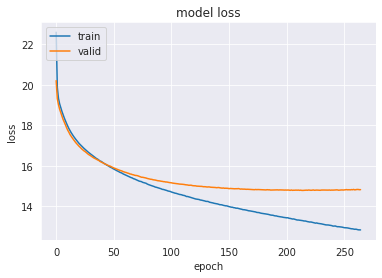

In [24]:
#%autoreload 2
(history_list, 

#scores_valid_list,
scores_test_list, 

#function_values_valid_list, 
function_values_test_list, 

#polynomial_dict_valid_list,
polynomial_dict_test_list,

#distrib_dict_valid_list,
distrib_dict_test_list,

model_list) = calculate_interpretation_net_results(lambda_net_train_dataset_list, 
                                                   lambda_net_valid_dataset_list, 
                                                   lambda_net_test_dataset_list)



## Evaluate Interpretation Net

In [25]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

In [26]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 176)]        0                                            
__________________________________________________________________________________________________
hidden1_512 (Dense)             (None, 512)          90624       input[0][0]                      
__________________________________________________________________________________________________
activation1_relu (Activation)   (None, 512)          0           hidden1_512[0][0]                
__________________________________________________________________________________________________
dropout1_0.25 (Dropout)         (None, 512)          0           activation1_relu[0][0]           
______________________________________________________________________________________________

In [27]:
if evaluate_with_real_function:
    keys = ['inetPoly_VS_targetPoly_test', 'perNetworkPoly_VS_targetPoly_test', 'predLambda_VS_targetPoly_test', 'lstsqLambda_VS_targetPoly_test', 'lstsqTarget_VS_targetPoly_test']
else:
    keys = ['inetPoly_VS_predLambda_test', 'inetPoly_VS_lstsqLambda_test', 'perNetworkPoly_VS_predLambda_test', 'perNetworkPoly_VS_lstsqLambda_test', 'lstsqLambda_VS_predLambda_test', 'predLambda_VS_targetPoly_test']

In [28]:
scores_test_list[-1]

,MAE,RMSE,MAPE,Accuracy,Accuracy Multilabel,MAE FV,RMSE FV,MAPE FV,R2 FV,RAAE FV,RMAE FV,MEAN STD FV DIFF,MEAN FV1,MEAN FV2,STD FV1,STD FV2
lambda_preds_VS_target_polynomials,NaN,NaN,NaN,NaN,NaN,0.013,0.017,0.411,0.995,0.050,0.331,0.017,-0.021,-0.020,0.449,0.451
lambda_preds_VS_lstsq_lambda_pred_polynomials,NaN,NaN,NaN,NaN,NaN,0.012,0.016,0.371,0.996,0.048,0.269,0.016,-0.021,-0.021,0.449,0.449
lambda_preds_VS_lstsq_target_polynomials,NaN,NaN,NaN,NaN,NaN,0.013,0.017,0.411,0.995,0.050,0.331,0.017,-0.021,-0.020,0.449,0.451
lambda_preds_VS_inet_polynomials,NaN,NaN,NaN,NaN,NaN,0.212,0.250,4.823,-0.329,0.833,1.685,0.150,-0.021,0.005,0.449,0.585
target_polynomials_VS_lstsq_lambda_pred_polynomials,0.061,0.091,5.182,0.581,0.000,0.008,0.011,0.294,0.998,0.032,0.231,0.011,-0.020,-0.021,0.451,0.449
target_polynomials_VS_lstsq_target_polynomials,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,-0.020,-0.020,0.451,0.451
target_polynomials_VS_inet_polynomials,0.384,0.471,32.976,0.086,0.000,0.211,0.250,5.440,-0.303,0.823,1.787,0.151,-0.020,0.005,0.451,0.585
lstsq_lambda_pred_polynomials_VS_lstsq_target_polynomials,0.061,0.091,4.727,0.581,0.000,0.008,0.011,0.293,0.998,0.032,0.181,0.011,-0.021,-0.020,0.449,0.451
lstsq_lambda_pred_polynomials_VS_inet_polynomials,0.388,0.471,2211.708,0.080,0.000,0.211,0.249,5.336,-0.329,0.833,1.756,0.149,-0.021,0.005,0.449,0.585
lstsq_target_polynomials_VS_inet_polynomials,0.384,0.471,32.976,0.086,0.000,0.211,0.250,5.440,-0.303,0.823,1.787,0.151,-0.020,0.005,0.451,0.585


In [29]:
distrib_dict_test_list[-1]['MAE']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99
lambda_preds_VS_target_polynomials,0.018,0.015,0.016,0.015,0.010,0.009,0.012,0.012,0.012,0.015,0.013,0.027,0.013,0.014,0.015,0.009,0.007,0.012,0.011,0.013,0.011,0.034,0.014,0.014,0.009,0.005,0.017,0.008,0.013,0.013,0.010,0.009,0.009,0.012,0.009,0.007,0.012,0.011,0.009,0.009,0.028,0.011,0.007,0.005,0.010,0.014,0.015,0.015,0.008,0.012,0.009,0.012,0.018,0.007,0.008,0.023,0.011,0.007,0.013,0.009,0.012,0.011,0.006,0.013,0.012,0.009,0.015,0.023,0.006,0.014,0.011,0.014,0.020,0.010,0.018,0.008,0.012,0.021,0.021,0.021,0.012,0.008,0.020,0.008,0.007,0.009,0.023,0.014,0.019,0.009,0.009,0.016,0.009,0.012,0.009,0.013,0.006,0.009,0.017,0.007
lambda_preds_VS_lstsq_lambda_pred_polynomials,0.017,0.014,0.015,0.015,0.011,0.010,0.012,0.012,0.013,0.015,0.013,0.024,0.013,0.013,0.012,0.009,0.007,0.012,0.010,0.011,0.010,0.033,0.012,0.014,0.009,0.006,0.015,0.008,0.014,0.013,0.009,0.008,0.009,0.010,0.009,0.006,0.013,0.011,0.009,0.009,0.026,0.011,0.006,0.005,0.009,0.014,0.015,0.013,0.009,0.011,0.009,0.011,0.018,0.007,0.008,0.020,0.011,0.007,0.012,0.008,0.011,0.011,0.006,0.012,0.012,0.009,0.014,0.021,0.005,0.014,0.012,0.013,0.020,0.010,0.017,0.008,0.013,0.020,0.019,0.021,0.011,0.007,0.019,0.007,0.007,0.008,0.022,0.014,0.016,0.009,0.008,0.015,0.010,0.010,0.009,0.012,0.006,0.009,0.016,0.007
lambda_preds_VS_lstsq_target_polynomials,0.018,0.015,0.016,0.015,0.010,0.009,0.012,0.012,0.012,0.015,0.013,0.027,0.013,0.014,0.015,0.009,0.007,0.012,0.011,0.013,0.011,0.034,0.014,0.014,0.009,0.005,0.017,0.008,0.013,0.013,0.010,0.009,0.009,0.012,0.009,0.007,0.012,0.011,0.009,0.009,0.028,0.011,0.007,0.005,0.010,0.014,0.015,0.015,0.008,0.012,0.009,0.012,0.018,0.007,0.008,0.023,0.011,0.007,0.013,0.009,0.012,0.011,0.006,0.013,0.012,0.009,0.015,0.023,0.006,0.014,0.011,0.014,0.020,0.010,0.018,0.008,0.012,0.021,0.021,0.021,0.012,0.008,0.020,0.008,0.007,0.009,0.023,0.014,0.019,0.009,0.009,0.016,0.009,0.012,0.009,0.013,0.006,0.009,0.017,0.007
lambda_preds_VS_inet_polynomials,0.099,0.247,0.172,0.797,0.133,0.591,0.189,0.060,0.143,0.172,0.075,0.193,0.120,0.224,0.359,0.313,0.356,0.162,0.237,0.068,0.265,0.401,0.062,0.239,0.131,0.060,0.136,0.126,0.064,0.189,0.283,0.187,0.135,0.370,0.166,0.420,0.134,0.269,0.253,0.050,0.519,0.156,0.066,0.297,0.102,0.218,0.103,0.139,0.144,0.437,0.056,0.153,0.382,0.216,0.103,0.214,0.117,0.155,0.516,0.067,0.091,0.115,0.265,0.160,0.509,0.097,0.137,0.071,0.226,0.195,0.229,0.093,0.481,0.196,0.168,0.551,0.165,0.683,0.444,0.391,0.068,0.055,0.315,0.172,0.047,0.445,0.155,0.154,0.114,0.081,0.188,0.196,0.040,0.134,0.138,0.103,0.239,0.122,0.229,0.093
target_polynomials_VS_lstsq_lambda_pred_polynomials,0.014,0.010,0.010,0.008,0.006,0.005,0.008,0.006,0.009,0.010,0.009,0.019,0.006,0.009,0.011,0.004,0.005,0.009,0.006,0.008,0.006,0.026,0.010,0.008,0.006,0.003,0.011,0.004,0.010,0.007,0.008,0.006,0.006,0.008,0.006,0.005,0.006,0.006,0.006,0.006,0.025,0.007,0.004,0.003,0.007,0.009,0.009,0.009,0.005,0.007,0.005,0.009,0.011,0.004,0.006,0.016,0.007,0.004,0.008,0.007,0.008,0.006,0.004,0.010,0.009,0.006,0.010,0.016,0.003,0.007,0.008,0.009,0.011,0.006,0.011,0.004,0.008,0.011,0.015,0.013,0.009,0.005,0.014,0.005,0.005,0.006,0.011,0.009,0.016,0.007,0.006,0.009,0.005,0.010,0.005,0.008,0.004,0.005,0.010,0.004
target_polynomials_VS_lstsq_target_polynomials,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0

In [30]:
distrib_dict_test_list[-1]['R2']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99
lambda_preds_VS_target_polynomials,0.993,0.987,0.996,0.995,0.996,0.998,0.996,0.994,0.997,0.995,0.992,0.987,0.998,0.993,0.995,0.997,0.999,0.997,0.997,0.982,0.996,0.992,0.995,0.998,0.996,0.998,0.994,0.999,0.994,0.998,0.998,0.996,0.995,0.998,0.998,0.998,0.997,0.999,0.999,0.998,0.985,0.993,0.989,0.996,0.997,0.995,0.998,0.998,0.998,0.998,0.997,0.998,0.997,0.997,0.995,0.986,0.993,0.995,0.997,0.997,0.998,0.997,0.999,0.991,0.995,0.995,0.995,0.991,0.999,0.995,0.997,0.977,0.997,0.989,0.987,0.998,0.997,0.993,0.995,0.991,0.996,0.989,0.991,0.998,0.992,0.994,0.997,0.995,0.984,0.988,0.996,0.980,0.997,0.994,0.997,0.994,0.998,0.999,0.992,0.999
lambda_preds_VS_lstsq_lambda_pred_polynomials,0.995,0.990,0.997,0.995,0.996,0.998,0.997,0.995,0.997,0.995,0.994,0.990,0.998,0.994,0.997,0.997,0.999,0.997,0.997,0.988,0.996,0.993,0.996,0.998,0.997,0.998,0.996,0.999,0.994,0.998,0.998,0.997,0.995,0.999,0.998,0.999,0.997,0.999,0.999,0.999,0.990,0.994,0.993,0.996,0.998,0.995,0.998,0.998,0.998,0.998,0.997,0.998,0.997,0.997,0.996,0.991,0.994,0.995,0.997,0.998,0.998,0.997,0.999,0.993,0.996,0.996,0.996,0.994,0.999,0.995,0.997,0.983,0.998,0.991,0.991,0.998,0.997,0.994,0.997,0.992,0.998,0.991,0.994,0.999,0.993,0.996,0.997,0.995,0.991,0.992,0.997,0.984,0.997,0.997,0.997,0.995,0.998,0.999,0.993,0.999
lambda_preds_VS_lstsq_target_polynomials,0.993,0.987,0.996,0.995,0.996,0.998,0.996,0.994,0.997,0.995,0.992,0.987,0.998,0.993,0.995,0.997,0.999,0.997,0.997,0.982,0.996,0.992,0.995,0.998,0.996,0.998,0.994,0.999,0.994,0.998,0.998,0.996,0.995,0.998,0.998,0.998,0.997,0.999,0.999,0.998,0.985,0.993,0.989,0.996,0.997,0.995,0.998,0.998,0.998,0.998,0.997,0.998,0.997,0.997,0.995,0.986,0.993,0.995,0.997,0.997,0.998,0.997,0.999,0.991,0.995,0.995,0.995,0.991,0.999,0.995,0.997,0.977,0.997,0.989,0.987,0.998,0.997,0.993,0.995,0.991,0.996,0.989,0.991,0.998,0.992,0.994,0.997,0.995,0.984,0.988,0.996,0.980,0.997,0.994,0.997,0.994,0.998,0.999,0.992,0.999
lambda_preds_VS_inet_polynomials,0.825,-2.092,0.633,-7.752,0.526,-5.001,0.353,0.878,0.556,0.315,0.811,0.200,0.832,-0.762,-1.005,-1.854,-0.819,0.444,-0.473,0.527,-0.756,0.081,0.880,0.395,0.401,0.803,0.683,0.748,0.863,0.633,0.005,-0.607,0.057,-0.264,0.338,-2.031,0.620,0.470,0.463,0.963,-1.734,-0.380,0.030,-8.135,0.661,0.095,0.911,0.809,0.684,-1.170,0.889,0.706,-0.244,-0.789,0.462,-0.011,0.274,-1.709,-2.022,0.836,0.856,0.657,-0.647,-0.095,-4.286,0.609,0.563,0.935,0.368,0.050,0.096,0.178,-0.110,-2.203,-0.153,-5.286,0.471,-3.617,-0.520,-0.762,0.920,0.490,-0.726,0.326,0.631,-7.141,0.852,0.289,0.545,0.488,-0.380,-1.404,0.943,0.426,0.198,0.659,-0.498,0.808,-0.275,0.801
target_polynomials_VS_lstsq_lambda_pred_polynomials,0.996,0.994,0.999,0.999,0.999,0.999,0.998,0.999,0.998,0.997,0.997,0.993,0.999,0.997,0.997,0.999,0.999,0.998,0.999,0.993,0.998,0.996,0.997,0.999,0.999,1.000,0.998,1.000,0.997,0.999,0.999,0.998,0.998,0.999,0.999,0.999,0.999,1.000,1.000,0.999,0.989,0.997,0.996,0.999,0.998,0.998,0.999,0.999,0.999,0.999,0.999,0.999,0.999,0.999,0.998,0.993,0.997,0.998,0.999,0.998,0.999,0.999,0.999,0.995,0.997,0.998,0.998,0.996,1.000,0.998,0.999,0.993,0.999,0.996,0.995,1.000,0.998,0.998,0.997,0.997,0.998,0.995,0.995,0.999,0.996,0.998,0.999,0.998,0.989,0.995,0.998,0.994,0.999,0.996,0.999,0.998,0.999,0.999,0.997,1.000
target_polynomials_VS_lstsq_target_polynomials,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.

In [31]:
index_min = int(np.argmin(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials']))

print(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][index_min])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

0.9832747207004329


0.0759329308893903*a**3 - 0.0719451328070053*a**2*b + 0.0296066783629383*a**2*c - 0.0057064923545816*a**2*d - 0.0271648564451908*a**2*e + 0.163557428748695*a**2 + 0.17279203299053*a*b**2 - 0.0153086602318086*a*b*c - 0.620395408440938*a*b*d - 0.0891704723781628*a*b*e - 0.140865333920292*a*b + 0.0474258605202568*a*c**2 + 0.0148556156505617*a*c*d + 0.0127977291053069*a*c*e - 0.0909514185859315*a*c + 0.0134445692255047*a*d**2 + 0.022981384226603*a*d*e + 0.130041522217451*a*d + 0.058544423283613*a*e**2 + 0.0094782495754993*a*e + 0.115780672774903*a + 0.0487670292500038*b**3 + 0.046861322916476*b**2*c + 0.0416219939416266*b**2*d - 0.0061850465351766*b**2*e - 0.22152904855611*b**2 - 0.0105596070593319*b*c**2 + 0.0328027481220507*b*c*d + 0.0050126737795453*b*c*e - 0.0532527560104318*b*c - 0.0568453236311847*b*d**2 - 0.0287590475034933*b*d*e - 0.0796400822772811*b*d + 0.0171235130948876*b*e**2 + 0.0387710940011307*b*e + 0.171948835031022*b + 0.0136083475111223*c**3 + 0.0194970541056848*c**2*d +

In [32]:
r2_values_inet = distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_inet_polynomials']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



Mean: -0.328955738079684 (100 Samples)
Mean (only positive): 0.5526905447985246 (63 Samples)


In [33]:
r2_values_lstsq_lambda = distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



Mean: 0.9957221066015284 (100 Samples)
Mean (only positive): 0.9957221066015284 (100 Samples)


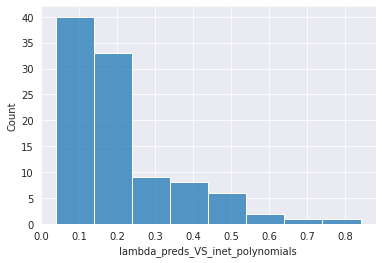

In [34]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


[(0.0, 1.0)]

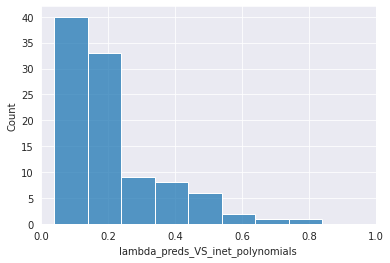

In [35]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


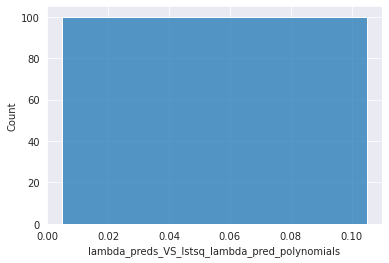

In [36]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


[(0.0, 1.0)]

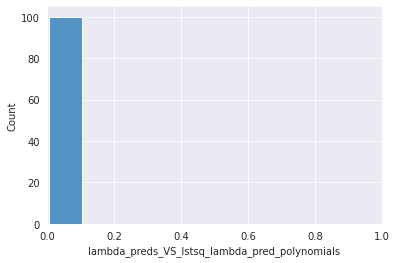

In [37]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


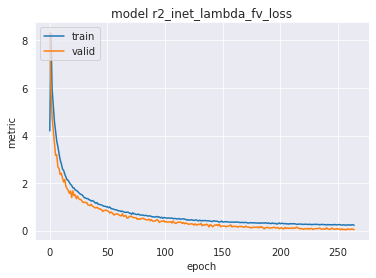

In [38]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


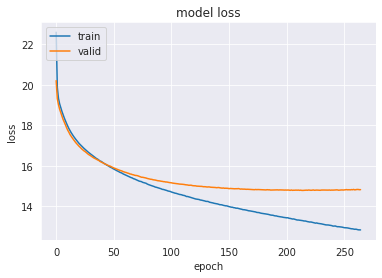

In [39]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

In [40]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [41]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [42]:
if len(scores_test_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [43]:
lstsq_data = np.random.uniform(low=x_min, high=x_max, size=(1, n)) #y_train_pred_lambda.ravel()
print(lstsq_data)
terms_matrix = generate_term_matric_for_lstsq(lstsq_data, list_of_monomial_identifiers)
print(terms_matrix)

[[0.82751892 0.76452779 0.57352895 0.95604714 0.20047452]]
[[0.56667467 0.52353913 0.39274549 0.6546892  0.13728246 0.68478757
  0.48368708 0.36284952 0.60485395 0.12683245 0.63266122 0.27220032
  0.45374577 0.09514642 0.47460606 0.75637393 0.15860483 0.7911471
  0.03325801 0.16589645 0.82751892 0.4468686  0.33522925 0.55881218
  0.11717791 0.58450275 0.2514803  0.41920643 0.08790383 0.43847882
  0.69879839 0.14653176 0.73092461 0.0307264  0.15326834 0.76452779
  0.18865401 0.31447781 0.06594318 0.32893546 0.52422045 0.10992433
  0.54832072 0.02305015 0.11497794 0.57352895 0.87385208 0.18323895
  0.91402614 0.03842356 0.19166309 0.95604714 0.00805708 0.04019003
  0.20047452 1.        ]]


In [44]:
polynomial_dict_test_list[-1]['target_polynomials'][index]

NameError: name 'index' is not defined

In [ ]:
lambda_net_test_dataset_list[-1].target_polynomial_list[index]

In [ ]:
lambda_net_test_dataset_list[-1].X_test_data_list[index]

In [ ]:
function_values_test_list[-1]['target_polynomials'][index]

In [ ]:
lstsq_data = lambda_net_test_dataset_list[-1].X_test_data_list[index] #np.random.uniform(low=x_min, high=x_max, size=(2, n)) #y_train_pred_lambda.ravel()
print(lstsq_data.shape)

terms_matrix = generate_term_matric_for_lstsq(lstsq_data, list_of_monomial_identifiers)
print(terms_matrix.shape)

y_data = function_values_test_list[-1]['target_polynomials'][index]

polynomial_lstsq_true, _, _, _ = np.linalg.lstsq(terms_matrix, y_data, rcond=-1)#[::-1] 
print(polynomial_lstsq_true.shape)

In [ ]:
polynomial_lstsq_true

In [ ]:
index = 6

custom_representation_keys_fixed = ['target_polynomials', 'lstsq_target_polynomials', 'lstsq_lambda_pred_polynomials', 'lstsq_lambda_pred_polynomials']
custom_representation_keys_dynamic = ['inet_polynomials', 'per_network_polynomials']
sympy_representation_keys = ['metamodel_functions']


print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')

for key in polynomial_dict_test_list[-1].keys():
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print(key)
    if key in custom_representation_keys_fixed:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], force_complete_poly_representation=True, round_digits=4)
    elif key in custom_representation_keys_dynamic:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], round_digits=4)
    else:
        display(polynomial_dict_test_list[-1][key][index])

print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=1)

In [ ]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=2)

In [ ]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=3)

# BENCHMARK (RANDOM GUESS) EVALUATION

In [ ]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [ ]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

In [ ]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

In [ ]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [ ]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

In [ ]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

In [ ]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [ ]:
lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
current_jobs = 1

lr=0.5
max_steps = 100
early_stopping=10
restarts=2
per_network_dataset_size = 500

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

if n_jobs != -1:
    n_jobs_per_network = min(n_jobs, os.cpu_count() // current_jobs)
else: 
    n_jobs_per_network = os.cpu_count() // current_jobs - 1

printing = True if n_jobs_per_network == 1 else False


lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
if evaluate_with_real_function: #target polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.target_polynomial_list)
else: #lstsq lambda pred polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list)


config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }


lambda_network_weights = lambda_network_weights_list[0]
poly_representation = poly_representation_list[0]



per_network_poly_optimization_tf(per_network_dataset_size, 
                                lambda_network_weights, 
                                  list_of_monomial_identifiers_numbers, 
                                  config, 
                                  lr=lr, 
                                  max_steps = max_steps, 
                                  early_stopping=early_stopping, 
                                  restarts=restarts, 
                                  printing=True)


# Evaluate Real Dataset


##  Auto MPG-Dataset

In [ ]:
interpretation_possible_autoMPG = False
print_head_autoMPG = None

url_autoMPG = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names_autoMPG = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset_autoMPG = pd.read_csv(url_autoMPG, names=column_names_autoMPG,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset_autoMPG = raw_dataset_autoMPG.dropna()

dataset_autoMPG['Origin'] = dataset_autoMPG['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset_autoMPG = pd.get_dummies(dataset_autoMPG, columns=['Origin'], prefix='', prefix_sep='')


features_autoMPG = dataset_autoMPG.copy()

labels_autoMPG = features_autoMPG.pop('MPG')

features_autoMPG_normalized = (features_autoMPG-features_autoMPG.min())/(features_autoMPG.max()-features_autoMPG.min())

#labels_autoMPG = (labels_autoMPG-labels_autoMPG.min())/(labels_autoMPG.max()-labels_autoMPG.min())


if features_autoMPG_normalized.shape[1] >= n:
    if n == 1:
        features_autoMPG_model = features_autoMPG_normalized[['Horsepower']]
    elif n == features_autoMPG_normalized.shape[1]:
        features_autoMPG_model = features_autoMPG_normalized
    else:
        features_autoMPG_model = features_autoMPG_normalized.sample(n=n, axis='columns')
        
    print_head_autoMPG = features_autoMPG_model.head()
    interpretation_possible_autoMPG = True

print_head_autoMPG

In [ ]:
#%load_ext autoreload

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    ((lambda_index_autoMPG, 
     current_seed_autoMPG, 
     polynomial_autoMPG, 
     polynomial_lstsq_pred_list_autoMPG, 
     polynomial_lstsq_true_list_autoMPG), 
    scores_list_autoMPG, 
    pred_list_autoMPG, 
    history_autoMPG, 
    model_autoMPG) = train_nn(lambda_index=0, 
                              X_data_lambda=features_autoMPG_model.values, 
                              y_data_real_lambda=labels_autoMPG.values, 
                              polynomial=None, 
                              seed_list=[RANDOM_SEED], 
                              callbacks=[PlotLossesKerasTF()], 
                              return_history=True, 
                              each_epochs_save=None, 
                              printing=False, 
                              return_model=True)
    
    polynomial_lstsq_pred_autoMPG = polynomial_lstsq_pred_list_autoMPG[-1]

In [ ]:
if interpretation_possible_autoMPG and n==1:
    x = tf.linspace(0.0, 250, 251)
    y = model_autoMPG.predict(x)

    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
config = {
        'n': n,
        'd': d,
        'inet_loss': inet_loss,
        'sparsity': sparsity,
        'lambda_network_layers': lambda_network_layers,
        'interpretation_net_output_shape': interpretation_net_output_shape,
        'RANDOM_SEED': RANDOM_SEED,
        'nas': nas,
        'number_of_lambda_weights': number_of_lambda_weights,
        'interpretation_net_output_monomials': interpretation_net_output_monomials,
        'fixed_initialization_lambda_training': fixed_initialization_lambda_training,
        'dropout': dropout,
        'lambda_network_layers': lambda_network_layers,
        'optimizer_lambda': optimizer_lambda,
        'loss_lambda': loss_lambda,        
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }

weights_autoMPG = model_autoMPG.get_weights()

weights_flat_autoMPG = []
for layer_weights, biases in pairwise(weights_autoMPG):    #clf.get_weights()
    for neuron in layer_weights:
        for weight in neuron:
            weights_flat_autoMPG.append(weight)
    for bias in biases:
        weights_flat_autoMPG.append(bias)
        
weights_flat_autoMPG = np.array(weights_flat_autoMPG)


x = pred_list_autoMPG['X_test_lambda']
y = pred_list_autoMPG['y_test_real_lambda']

y_model_autoMPG = model_autoMPG.predict(x)




In [ ]:
if interpretation_possible_autoMPG:
    y_polynomial_lstsq_pred_autoMPG = calculate_function_values_from_polynomial(polynomial_lstsq_pred_autoMPG, x, force_complete_poly_representation=True)

    mae_model_polynomial_lstsq_pred_autoMPGy = mean_absolute_error(y_model_autoMPG, y_polynomial_lstsq_pred_autoMPG)
    mae_data_polynomial_lstsq_pred_autoMPG = mean_absolute_error(y, y_polynomial_lstsq_pred_autoMPG)

    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQt Poly:')
    print_polynomial_from_coefficients(y_polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('MAE Model: ', mae_model_polynomial_lstsq_pred_autoMPGy)
    print('MAE Data: ', mae_data_polynomial_lstsq_pred_autoMPG)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    interpretation_net = model_list[-1]
    
    start = time.time() 
    
    #interpretation_net_poly = interpretation_net.predict(np.array([weights_flat_autoMPG]))[0]
    interpretation_net_poly = make_inet_prediction(interpretation_net, weights_flat_autoMPG, network_data=None, lambda_trained_normalized=False, inet_training_normalized=normalize_inet_data, normalization_parameter_dict=None)
    
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_interpretation_net_poly = calculate_function_values_from_polynomial(interpretation_net_poly, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_interpretation_net_poly)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_interpretation_net_poly)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)    
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG:

    start = time.time() 
    
    if False:
        per_network_hyperparams = {
            'optimizer':  'Powell',
            'jac': 'fprime',
            'max_steps': 5000,#100,
            'restarts': 3,
            'per_network_dataset_size': 500,
        }      
        
        per_network_function =  per_network_poly_optimization_scipy(per_network_dataset_size, 
                                                                  weights_flat_autoMPG, 
                                                                  list_of_monomial_identifiers_numbers, 
                                                                  config, 
                                                                  optimizer = per_network_hyperparams['optimizer'],
                                                                  jac = per_network_hyperparams['jac'],
                                                                  max_steps = per_network_hyperparams['max_steps'], 
                                                                  restarts=per_network_hyperparams['restarts'], 
                                                                  printing=True,
                                                                  return_error=False)
    else:
        per_network_hyperparams = {
            'optimizer': tf.keras.optimizers.RMSprop,
            'lr': 0.02,
            'max_steps': 500,
            'early_stopping': 10,
            'restarts': 3,
            'per_network_dataset_size': 5000,
        }   
        
        per_network_function =  per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                              weights_flat_autoMPG, 
                                                              list_of_monomial_identifiers_numbers, 
                                                              config, 
                                                              optimizer = per_network_hyperparams['optimizer'],
                                                              lr=per_network_hyperparams['lr'], 
                                                              max_steps = per_network_hyperparams['max_steps'], 
                                                              early_stopping=per_network_hyperparams['early_stopping'], 
                                                              restarts=per_network_hyperparams['restarts'], 
                                                              printing=True,
                                                              return_error=False)
            
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)  
    
    y_per_network_function = calculate_function_values_from_polynomial(per_network_function, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_per_network_function)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_per_network_function)    
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)       
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
#%load_ext autoreload

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    
    symbolic_regression_hyperparams = {
        'dataset_size': 500,
    }

    start = time.time() 
    
    symbolic_regression_function =  symbolic_regression(model_autoMPG, 
                                                      config,
                                                      symbolic_regression_hyperparams,
                                                      #printing = True,
                                                      return_error = False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    variable_names = ['X' + str(i) for i in range(n)]
    
    y_symbolic_regression_function = calculate_function_values_from_sympy(symbolic_regression_function, x, variable_names=variable_names)
    
    mae_model_symbolic_regression_function = mean_absolute_error(y_model_autoMPG, y_symbolic_regression_function)
    mae_data_symbolic_regression_function = mean_absolute_error(y, y_symbolic_regression_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Poly:')    
    display(symbolic_regression_function)
    print('MAE Model: ', mae_model_symbolic_regression_function)
    print('MAE Data: ', mae_data_symbolic_regression_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG and True:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = False,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function = calculate_function_values_from_sympy(metamodel_function, x)
    
    mae_model_metamodel_function = mean_absolute_error(y_model_autoMPG, y_metamodel_function)
    mae_data_metamodel_function = mean_absolute_error(y, y_metamodel_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')    
    display(metamodel_function)
    print('MAE Model: ', mae_model_metamodel_function)
    print('MAE Data: ', mae_data_metamodel_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG and False:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function_basic =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = True,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function_basic = calculate_function_values_from_sympy(metamodel_function_basic, x)
    
    mae_metamodel_function_basic = mean_absolute_error(y_model_autoMPG, y_metamodel_function_basic)
    mae_metamodel_function_basic = mean_absolute_error(y, y_metamodel_function_basic)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function Basic:')    
    display(metamodel_function_basic)
    print('MAE Model: ', mae_metamodel_function_basic)
    print('MAE Data: ', mae_metamodel_function_basic)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG:
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQ Poly:')
    print_polynomial_from_coefficients(polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Function:')
    display(symbolic_regression_function)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')
    display(metamodel_function)
    #print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    #print('Metamodel Function Basic:')
    #display(metamodel_function_basic)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
if interpretation_possible_autoMPG and n==1:
    fig, ax = plt.subplots(1, 1, figsize=(20,10))
    
    ax.set_ylim([0,50])
    
    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.scatter(x, y, label='Test Data')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_model_autoMPG))]) , label='Model Predictions')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_interpretation_net_poly))]) , label='Interpretation Net Poly')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_per_network_function))]) , label='Per Network Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_polynomial_lstsq_pred_autoMPG))]) , label='LSTSQ Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_symbolic_regression_function))]) , label='Symbolic Regression Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_metamodel_function))]) , label='Metamodel Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y))]) y_metamodel_function_basic, label='Metamodel Function Basic')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
sample_data_X = np.array([i for i in range(1000)])
sample_data_y = np.array([3*i for i in range(1000)])

current_seed = 42

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y*1000,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y+1000,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:


model_2_weights = model.get_weights()
model_2_normalized_weights = model_2_weights #[weights/10 for weights in model_2_weights]


model_2_normalized_weights[-6] = model_2_normalized_weights[-6]/10
model_2_normalized_weights[-5] = model_2_normalized_weights[-5]/10

model_2_normalized_weights[-4] = model_2_normalized_weights[-4]/10
model_2_normalized_weights[-3] = model_2_normalized_weights[-3]/100

model_2_normalized_weights[-2] = model_2_normalized_weights[-2]/10
model_2_normalized_weights[-1] = model_2_normalized_weights[-1]/1000

model_2.set_weights(model_2_normalized_weights)

print(model_2.get_weights())
print(model_2.predict([1, 10]))

# Evaluate Per-Network Poly Optimization

## Example Optimization (Common Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer':  'Powell',
    'jac': 'fprime',
    'max_steps': 5000,#100,
    'restarts': 3,
    'per_network_dataset_size': 500,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_scipy(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      jac = per_network_hyperparams['jac'],
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Example Optimization (Neural Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer': tf.keras.optimizers.RMSprop,
    'lr': 0.02,
    'max_steps': 500,
    'early_stopping': 10,
    'restarts': 3,
    'per_network_dataset_size': 5000,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      lr = per_network_hyperparams['lr'], 
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      early_stopping = per_network_hyperparams['early_stopping'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error.numpy()))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Grid Search Common Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 10

per_network_hyperparams = {
    'optimizer':  [
                   'Nelder-Mead', 
                   'Powell', 
        
                   'CG',
                   'BFGS',
                   'Newton-CG', 
                   #'L-BFGS-B', #'>' not supported between instances of 'int' and 'NoneType'
                   'TNC', 
                   
                   'COBYLA', 
                   'SLSQP', 
                   
                   #'trust-constr', # TypeError: _minimize_trustregion_constr() got an unexpected keyword argument 'maxfun'
                   #'dogleg', # ValueError: Hessian is required for dogleg minimization
                   #'trust-ncg', #ValueError: Either the Hessian or the Hessian-vector product is required for Newton-CG trust-region minimization
                   #'trust-exact', # ValueError: Hessian matrix is required for trust region exact minimization.
                   #'trust-krylov' #ValueError: Either the Hessian or the Hessian-vector product is required for Krylov trust-region minimization
                   ], 
    'jac': ['fprime'],
    'max_steps': [5000],#100,
    'restarts': [3],
    'per_network_dataset_size': [500],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_scipy)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  jac = params['jac'],
                                                                                  max_steps = params['max_steps'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

## Grid Search Neural Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 100

per_network_hyperparams = {
    'optimizer': [tf.keras.optimizers.RMSprop], #[tf.keras.optimizers.SGD, tf.optimizers.Adam, tf.keras.optimizers.RMSprop, tf.keras.optimizers.Adadelta]
    'lr': [0.02], #[0.5, 0.25, 0.1, 0.05, 0.025]
    'max_steps': [5000],#100,
    'early_stopping': [10],
    'restarts': [3],
    'per_network_dataset_size': [5000],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_tf)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  lr = params['lr'], 
                                                                                  max_steps = params['max_steps'], 
                                                                                  early_stopping = params['early_stopping'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

In [ ]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()